# Investigating angles

This is not a MC simulation; it is a test to see how much the likelihood depends on each parameter. 

In [1]:
# Import stuff
import numpy as np
import matplotlib.pyplot as pl
import os, pickle
import random

import smarty
from copy import deepcopy
from smarty import *
from smarty import forcefield
from samplingtools import *
import openeye
from openeye import oechem
from smarty.utils import get_data_filename

In [2]:
# Functions
def calculate_energies(smirk, key,
                       modify_key_by_type,
                       prange, number_of_points,
                       copyff, oemol, topology):
    xaxis = np.linspace(prange[key][0],prange[key][1], number_of_points)
    energies = np.zeros(len(xaxis))
    params = copyff.getParameter(smirks=smirk)
    backup = params.copy()
    for idx, element in enumerate(xaxis):
        params[key] = str(element)
        copyff.setParameter(params,smirks=smirk)
        system = copyff.createSystem(topology, [oemol])
        cpos = reformat_oemol_coordinates(oemol)
        energies[idx] = get_energy(system,cpos[:,:,0])
    return xaxis, energies

def plot_data(xaxis,yaxis,legend,smirks_tuple,yaxis_name):
    fig = pl.figure(figsize=(3.25,3.25))
    ax = fig.add_subplot(111)
    ax.plot(xaxis,yaxis,'bo',label=legend)
    ax.set_xlabel(key)
    ax.set_ylabel(yaxis_name)
    if smirks_tuple[1] > 35:
        title = smirks_tuple[1][:35]+'\n'+smirks_tuple[1][35:]
    else:
        title = smirks_tuple[1]
    ax.set_title(title,fontsize=10)
    pl.tight_layout()
    pl.savefig("%s_%s_%s.pdf" % (smirks_tuple[0],key,yaxis_name))
    pl.close(fig)
    return

def gaussian(mean, std, x):
    y = (1/(std *np.sqrt(2*np.pi)))*np.exp(-0.5*((x-mean)/std)**2)
    return y

def log_likelihood( z, mu, s_E):
    """Calculate a log likelihood and a likelihood given a calculated value, a set of `measured`/observed values
        (data we are fitting to) and a standard error in those measured values.
        
        
        Parameters
        ----------
        z : simtk.unit.Quantity of dimensions N
        Calculated values
        mu : simtk.unit.Quantity of dimensions N
        Mean (i.e. observed/measured values)
        s_E : simtk.unit.Quantity of dimensions N
        Standard error in the mean (uncertainty in observed/measured values)
        
        Returns
        -------
        loglike : float
        Natural logarithm of likelihood
        like : float
        Likelihood
        """
    # Adapted from https://github.com/shirtsgroup/lj_bayesian/blob/041b896d37f91f4b42cccb2df73af84a9cf5b917/generate_posterior.py#L117
    
    
    # Standardize units of input and strip units, if they have units
    try:
        unit_choice = z.unit
        clear_s_E = s_E.value_in_unit(unit_choice)
        clear_mu = mu.value_in_unit(unit_choice)
        clear_z = z.value_in_unit(unit_choice)
    except AttributeError:
        clear_s_E = s_E
        clear_mu = mu
        clear_z = z
    # If we've mixed things with units with things without units, the below will raise another attribute error
    
    # Compute log likelihood and likelihood
    # Gaussian is (2*pi*s_E^2)^(-1/2) e^(-(z-mu)^2 /2s_E^2)
    # log Gaussian is -1/2 * (log(2*pi) + 2*log(s_E)) -|z-mu|^2/(2s_E^2)
    # Here we will ignore the constant term because it drops out when taking ratios of probabilities
    loglike = 0.
    like = 0.
    for i, m in enumerate(clear_mu):
        this_s_E = clear_s_E[i]
        this_z = clear_z[i]
        gauss_arg = - ((m-this_z)**2)/(2.*this_s_E**2)
        loglike += gauss_arg - 0.5*np.log(2*np.pi*this_s_E**2)
    
    like = np.exp(loglike)
    return loglike, like

In [9]:
%matplotlib inline

In [10]:
# Load pre-generated data if already generated, otherwise re-generate
if os.path.isfile('ref_energies.pickle') and os.path.isfile('topologies.pickle') and os.path.isfile('oemols_molnames.pickle'):
    file = open('ref_energies.pickle', 'r')
    ref_energies = pickle.load(file)
    file.close()
    file = open('topologies.pickle', 'r')
    topologies = pickle.load(file)
    file = open('oemols_molnames.pickle', 'r')
    oemols, mol_names = pickle.load(file)
    file.close()
    print("Loaded reference data.")
else:
    print("Re-generating reference data.")
    os.system('python generate_reference_data.py')
    file = open('ref_energies.pickle', 'r')
    ref_energies = pickle.load(file)
    file.close()
    file = open('topologies.pickle', 'r')
    topologies = pickle.load(file)
    file = open('oemols_molnames.pickle', 'r')
    oemols, mol_names = pickle.load(file)
    file.close()
    print("Loaded reference data.")

if os.path.isfile('s_E_mean.pickle'):
    file = open('s_E_mean.pickle', 'r')
    s_E, mean_unc = pickle.load(file)
    file.close()
else:
    print("Re-generating uncertainty data.")
    os.system('python get_uncertainties.py')
    file = open('s_E_mean.pickle', 'r')
    s_E, mean_unc = pickle.load(file)
    file.close()

Loaded reference data.


##### Prep for energy calculation

In [11]:
# Get force field
ffxml = get_data_filename('forcefield/Frosst_AlkEtOH.ffxml')
ff = forcefield.ForceField(ffxml)
# Dictionary containig parameter types
modify_key_by_type = {'n':['rmin_half', 'epsilon'],'b':['length', 'k'], 'a':['angle','k'],'t':['k','periodicity','phase'], 'i':['k','periodicity','phase']}
# Define parameter range to consider
prange = {'rmin_half':[0.0, 3.], 'epsilon':[0.0, 0.1], 'length':[0.0,5.0], 'k':[0.,3000.], 'angle':[80.,140.]}
smirks_tuple = ('a0002','[#1:1]-[#6X4:2]-[#1:3]')
pkey = 'k'
pkey2 = 'angle'
mol = oemols[0] # this is methane!
top = topologies[0]
ref_E = ref_energies[0]
copyff = deepcopy(ff)
copyff2 = deepcopy(ff) # I decided to add a second copy to avoid re-using a modified forcefield object

It is very important to notice that $0 < k < 3000$ and the expected $k$s for our systems go from 50 to 1200 (angular and bonded $k$s).

##### Energy calculation

In [12]:
ks, energies = calculate_energies(smirks_tuple[1], pkey,
                                  modify_key_by_type,
                                  prange, 100,
                                  copyff, mol, top)
angles, energies2 = calculate_energies(smirks_tuple[1], pkey2,
                                       modify_key_by_type,
                                       prange, 100,
                                       copyff2, mol, top)

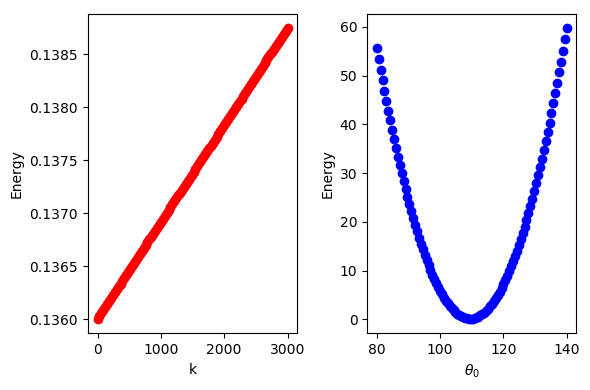

In [13]:
fig = pl.figure()
ax1 = fig.add_subplot(121)
ax1.plot(ks,energies,'ro')
ax1.set_xlabel('k')
ax1.set_ylabel('Energy')

ax2 = fig.add_subplot(122)
ax2.plot(angles,energies2,'bo')
ax2.set_xlabel(r'$\theta_0$')
ax2.set_ylabel('Energy')

pl.tight_layout()

I decided to calculate likelihoods using the function log_likelihood in samplingtools.py.

In [21]:
likelihood_k = np.zeros(len(ks))
log_k = np.zeros(len(ks))
for j, elem in enumerate(energies):
    log_k[j], likelihood_k[j] = log_likelihood([elem], [ref_E], [mean_unc])
    
likelihood_a = np.zeros(len(angles))
log_a = np.zeros(len(angles))
for j, elem in enumerate(energies2):
    log_a[j], likelihood_a[j] = log_likelihood([elem], [ref_E], [mean_unc])

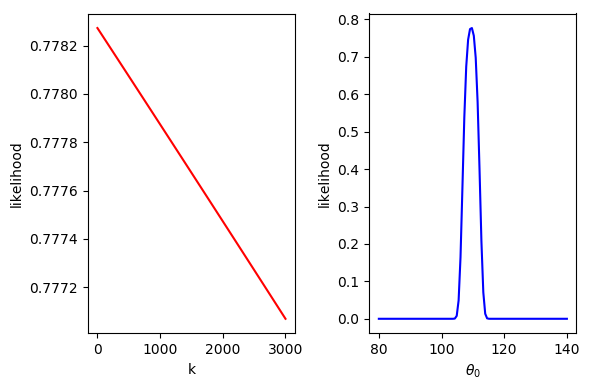

In [22]:
fig = pl.figure()
ax1 = fig.add_subplot(121)
ax1.plot(ks,likelihood_k,'r-')
ax1.set_xlabel('k')
ax1.set_ylabel('likelihood')

ax2 = fig.add_subplot(122)
ax2.plot(angles,likelihood_a, 'b-')
ax2.set_xlabel(r'$\theta_0$')
ax2.set_ylabel('likelihood')

pl.tight_layout()

I want to check where these likelihoods fall in the likelihood distribution wrt energy.
This is an approximate likelihood distribution wrt energy for methane:

In [17]:
test_en = np.linspace(0,ref_E+3*mean_unc,100) # probe energy values
gauss = gaussian(ref_E, mean_unc, test_en) # likelihood

The idea is to plot all the data together and see where in the distribution these values fall.

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x12b9e2710>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x12b9e9ad0>)

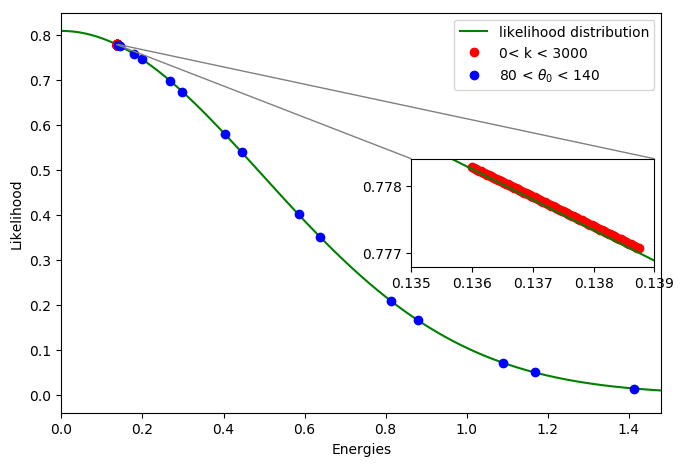

In [25]:
# Plot position of each sort of parameter on likelihood distribution
fig = pl.figure()

ax = fig.add_axes([.1,.1,1,1])
ax.plot(test_en, gauss, 'g-',label='likelihood distribution')
ax.plot(energies, likelihood_k, 'ro', label='0< k < 3000')
ax.plot(energies2, likelihood_a, 'bo', label=r'80 < $\theta_0$ < 140')
ax.set_ylabel('Likelihood')
ax.set_xlabel('Energies')
ax.set_xlim([0,3*mean_unc])
pl.legend()

axins = zoomed_inset_axes(ax,150,loc=7)
axins.plot(energies, likelihood_k, 'ro')
axins.plot(energies2, likelihood_a, 'bo')
axins.plot(test_en, gauss, 'g-')
axins.set_xlim(0.135,0.139)
axins.set_ylim(0.7768,0.7784)
mark_inset(ax, axins, loc1=1,loc2=2, fc='none', ec='0.5')

That's why I mentioned in last week's update that it seemed to me that the energy of the molecule seemed to be insensitive to k; all these values of k encompass a very narrow energy and likelihood change.

Let's frame it in the MC code context (code next markdown cell). Let $\alpha$ be the acceptance probability:

$$ \alpha = \min \{ 1, \frac{newlike}{oldlike} \cdot \frac{prior(\theta^{candidate})}{prior(\theta^{(i-1)})} \}$$

Lines 23 - 26 (see the MC code in the next markdown cell, if necessary) assure that the prior ratio will always be 1, so:

$$ \alpha = \min \Big \{ 1, \frac{newlike}{oldlike} \Big \}$$

The biggest likelihood value $q(k=0)$ equals to 0.778272832604;
The lowest likelihood value $q(k=3000)$ equals to 0.777069886946;

These values means that the lowest value that the acceptance probability can have is $\alpha =$ 0.998454339393, which reflects on the elevated acceptance ratios that I mentioned last week.


In [30]:
print(likelihood_k[0])
print(likelihood_k[-1])
print(likelihood_k[-1]/likelihood_k[0])

0.778272832604
0.777069886946
0.998454339393


#### Monte Carlo Loop

```
 1    # Do MC of parameter moves
 2    accepted_by_pkey={}
 3    for step in range(nsteps):
 4        # Pick a random smirks to change
 5        indices = range(len(tuplelist))
 6        smirks_tuple = tuplelist[random.choice(indices)]
 7        # Create subdictionaries
 8        if smirks_tuple[0] not in accepted_by_pkey:
 9            accepted_by_pkey[smirks_tuple[0]] = {}
10        # Pick a random parameter key to change
11        param_key = random.choice(modify_key_by_type[smirks_tuple[0][0]])
12        if not param_key in accepted_by_pkey[smirks_tuple[0]]:
13            accepted_by_pkey[smirks_tuple[0]][param_key] = {}
14            accepted_by_pkey[smirks_tuple[0]][param_key]['accepted']=0
15            accepted_by_pkey[smirks_tuple[0]][param_key]['total']=0
16        # Propose move
17        chg = random.uniform(-move_range[param_key],move_range[param_key])
18        # Get parameter value
19        params = moveff.getParameter(smirks=smirks_tuple[1])
20        paramval = float(params[param_key])
21        newparam = paramval + chg
22
23        # Focus only on things for which prior isn't zero
24        while uniform_prior(newparam, prange, param_key)==0:
25            chg = random.uniform(-move_range[param_key], move_range[param_key])
26            newparam = paramval + chg
27        # Prep for energy evaluation
28        params[param_key]=str(newparam)
29        moveff.setParameter(params, smirks=smirks_tuple[1])
30        # Get new energy and likelihood
31        for (idx, molid) in enumerate(molidx_list):
32            # Pull molecule
33            mol = oemols[molid]
34            # Create system for energy eval
35            topology = topologies[molid]
36            system=moveff.createSystem(topology, [mol])
37            # Get coordinates
38            cpositions = reformat_oemol_coordinates(mol)
39            # Get energy
40            calcE[idx] = get_energy(system, cpositions[:,:,0])
41        
42        newlog, newlike = log_likelihood(calcE, measE, meas_s_E)
43        
44        # Accept or reject move
45        Pacc = np.exp(newlog - oldlog) * uniform_prior(newparam, prange, param_key)/uniform_prior(paramval, prange, param_key)
46        accepted_by_pkey[smirks_tuple[0]][param_key]['total']+=1
47        if step%1==0:
48            outfile.write("Step %s, Smirk: %s\n" % (step,smirks_tuple[1]))
49            outfile.write("old %s: %.5f\n" % (param_key,paramval))
50            outfile.write("change: %.5f\n" % chg)
51            outfile.write("new %s: %.5f\n" % (param_key,newparam))
52        if step%500==0:
53            # Print some progress info every N steps
54            print("Step %s, Smirk: %s" % (step,smirks_tuple[1]))
55            print("old %s: %.5f" % (param_key,paramval))
56            print("change: %.5f" % chg)
57            print("new %s: %.5f" % (param_key,newparam))
58        # Acceptance test
59        accept = random.random() < Pacc
60        if not accept:
61            params[param_key] = str(paramval)
62            moveff.setParameter(params, smirks=smirks_tuple[1])
63        if accept:
64            # Update "old" stuff if we accepted
65            oldE = calcE
66            oldlog, oldlike = newlog, newlike
67            paramval = newparam
68            accepted_by_pkey[smirks_tuple[0]][param_key]['accepted']+=1
69        outfile.write("#steps accepted: %i\n" % accepted_by_pkey[smirks_tuple[0]][param_key]['accepted'])
70        outfile.write("#steps sampled: %i\n" % accepted_by_pkey[smirks_tuple[0]][param_key]['total'])

```